<a href="https://colab.research.google.com/github/chasubeen/ML_lab/blob/main/5_LDA_Gibbs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import numpy as np
from collections import defaultdict

# **1. Preprocessing**

## **1-1. Load data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data path

train_path = "/content/drive/MyDrive/ML_lab/2_LDA/data/pos_tag/train.txt"
test_path = "/content/drive/MyDrive/ML_lab/2_LDA/data/pos_tag/test.txt"

In [ ]:
def read_file(path):
  raw = open(path, 'r').read().split('\n') # 파일을 읽어와 줄마다 나누기
  data, doc = list(), list()

  for i, line in enumerate(raw):
    if line.strip(): # 빈 줄이 아니면
      word = line.split(' ')[0].lower() # 단어를 얻어온 후 소문자로 변환
      doc.append(word)
    else:
      data.append(doc) # EOD(End Of Document)
      doc = list()
  data.append(doc) # 맨 마지막 문서 추가

  return data

In [ ]:
# 데이터 불러오기
org_train_data = read_file(train_path)
org_test_data = read_file(test_path)

# 맨 마지막 문서는 제거
del org_train_data[-1], org_test_data[-1]

## **1-2. Preprocess Data**

In [ ]:
# some words that we do not want to consider
stopwords = ["", " ", 'the', 'to', 'of', 'a', 'and', 'in', 'for', "s", 'that', 'is', 'said', 'mr', 'on', 'by',
             'it', 'as', 'was', 'at', 'with', 'from', 'its', 'an', 'has', 'he', 'be', 'but', 'are', 'will',
             'have', 'or', "nt", 'his', 'they', 'were', 'this', 'which', 'would', 'about', 'year', 'had', 'been',
             'more', 'than', 'who', 'up', 'also', 'other', 'after', 'we', 'says', 'their', 'one', 'two', 'lrb',
             'rrb', 'years', 'when', 'some', 'may', 'could', 'quarter', 'yesterday', 'most', 'not', 'if',
             'because', 'there', 'first', 'i', 'any', 'last', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday',
             'saturday', 'sunday', 'before', 'no', 'week', 'much', 'so', 'such', 'can', 'while', 'into', 'do',
             'then', 'many', 'out', 'less', 'against', 'even', 'under', 'only', 'since', 'however', 'over', 'among',
             'between', 'them', 'him', 'those', 'did', 'you', 'still', 'these', 'three', 'own', 'second', 'off',
             'all', 'what', 'both', 'day', 'now', 'yet', 'during', 'according', 'including', 'she', 'my', 'days',
             'due', 'your', 'her', 'another', 'just', 'does', 'our', 'how', 'through', 'where', 'too', 'very', 'each',
             'days', 'month', 'months', 'should', 'several', 'few', 'ago']

In [ ]:
## remove numbers, special characters, etc.
# only consider words with alphabet

def only_alphabet(corpus, stopword_list=stopwords):
    pattern = re.compile('[^a-z]')
    # non-alphabet 문자 제거(=> 정규표현식 활용)
    return [
        [pattern.sub('', word) for word in doc if pattern.sub('', word) not in stopword_list] for doc in corpus
    ]

In [ ]:
train_data = only_alphabet(org_train_data)
test_data = only_alphabet(org_test_data)

In [ ]:
## count word occurrence in corpus

def count_vocab(corpus):
  vocab = defaultdict(int) # dictionary 형태로 word occurence를 기록
  for doc in corpus:
    for word in doc:
      vocab[word] += 1

  return vocab

In [ ]:
vocab_count = count_vocab(train_data)

In [ ]:
## 특정 빈도수 이상인 단어들만 고려
# sparse한 단어는 무시

def vocab_top(vocab,cnt):
  return {voca: count for voca, count in vocab.items() if count > cnt}

In [ ]:
vocab_count = vocab_top(vocab_count,cnt = 5)

In [ ]:
## filter out low-occurrence words

def filter_vocab(corpus, vocab):
    vocab_set = set(vocab)
    return [
        [word for word in doc if word in vocab_set] for doc in corpus
    ]

In [ ]:
train_data = filter_vocab(train_data,vocab_count)
test_data = filter_vocab(test_data,vocab_count)

In [ ]:
## construct voca-index-matching dictionary

def voca_index(vocab):
  vocab_to_index = {voca: i for i, voca in enumerate(vocab.keys())}
  index_to_vocab = {i: voca for i, voca in enumerate(vocab.keys())}

  return vocab_to_index, index_to_vocab

In [ ]:
v_t_i, i_t_v = voca_index(vocab_count)

In [ ]:
## convert corpus-with-words to corpus-with-index

def corpus_to_index(corpus,vocab_to_index):
  return [[vocab_to_index[word] for word in doc] for doc in corpus]

In [ ]:
train_data_idx = corpus_to_index(train_data,v_t_i)
test_data_idx = corpus_to_index(test_data,v_t_i)

# **2. Modeling**

In [ ]:
class LDA_CGS:
  ### Initialization
  def __init__(self, docs, num_topics=10, vocab=None, num_iter=100):
    self.docs = docs
    self.num_topics = num_topics
    self.vocab = vocab
    self.num_vocab = len(self.vocab)
    self.num_docs = len(self.docs)
    self.num_iter = num_iter

    ## Initialize alpha and beta
    self.alpha = np.ones(num_topics) * (1 / num_topics)
    self.beta = np.ones((num_topics, self.num_vocab)) * (1 / self.num_vocab)
    # Adding random noise to beta and normalizing
    self.beta += np.random.rand(num_topics, self.num_vocab) * 0.01
    self.beta /= np.sum(self.beta, axis=1)[:, np.newaxis]

    ## Initialize counts
    self.topic_word_counts = np.zeros((num_topics, self.num_vocab))  # 주제-단어 쌍
    self.topic_counts = np.zeros(num_topics)  # 해당 주제에서의 단어 총합
    self.doc_topic_counts = np.zeros((self.num_docs, num_topics))  # 문서-주제 할당
    self.topics = []

    # Initialize topics(z) for each word in the documents
    self.initialize()


  ### Initialize z: z^(0)
  def initialize(self):
    for d, doc in enumerate(self.docs):
      current_doc_topics = []
      for word_id in doc:
        topic = np.random.choice(self.num_topics)
        current_doc_topics.append(topic)

        self.topic_word_counts[topic, word_id] += 1
        self.topic_counts[topic] += 1
        self.doc_topic_counts[d, topic] += 1

      self.topics.append(current_doc_topics)


  ### Sampling
  def sample(self, d, word_id, topic):
    # Z_(m,n)에 대한 topic 할당 정보 제거
    self.topic_word_counts[topic, word_id] -= 1
    self.topic_counts[topic] -= 1
    self.doc_topic_counts[d, topic] -= 1

    topic_probs = np.zeros(self.num_topics)  # 초기화

    ## topic proportion 구하기
    for topic in range(self.num_topics):
      doc_topic_prob = (self.doc_topic_counts[d, topic] + self.alpha[topic]) / \
                        (len(self.topics[d]) - 1 + np.sum(self.alpha))

      topic_word_prob = (self.topic_word_counts[topic, word_id] + self.beta[topic, word_id]) / \
                        (self.topic_counts[topic] + np.sum(self.beta[topic, :]))
      topic_probs[topic] = doc_topic_prob * topic_word_prob
    topic_probs /= np.sum(topic_probs)

    # 새로운 topic sampling
    new_topic = np.random.choice(self.num_topics, p=topic_probs)

    # 주제 할당 정보 저장
    self.topic_word_counts[new_topic, word_id] += 1
    self.topic_counts[new_topic] += 1
    self.doc_topic_counts[d, new_topic] += 1

    return new_topic


  ### Compute Log Likelihood
  def compute_log_likelihood(self):
    log_likelihood = 0
    for d, doc in enumerate(self.docs):
      for n, word_id in enumerate(doc):
        word_likelihood = 0
        for topic in range(self.num_topics):
          word_likelihood += ((self.doc_topic_counts[d, topic] + self.alpha[topic]) /
                              (len(doc) + np.sum(self.alpha) - 1)) * \
                              ((self.topic_word_counts[topic, word_id] + self.beta[topic, word_id]) /
                              (self.topic_counts[topic] + np.sum(self.beta[topic, :])))
        log_likelihood += np.log(word_likelihood)
    return log_likelihood


  ### Compute Perplexity
  def compute_perplexity(self):
    total_words = sum(len(doc) for doc in self.docs)
    log_likelihood = self.compute_log_likelihood()
    perplexity = np.exp(-log_likelihood / total_words)
    return perplexity


  ### Compute Topic Coherence
  def compute_topic_coherence(self, top_n=10):
    coherence = 0.0
    for k in range(self.num_topics):
      top_words = np.argsort(self.topic_word_counts[k, :])[-top_n:]
      for i in range(top_n):
        for j in range(i + 1, top_n):
          word_i = top_words[i]
          word_j = top_words[j]
          coherence += np.log((self.topic_word_counts[k, word_j] + 1) /
                              (self.topic_word_counts[:, word_j].sum()))
    return coherence / self.num_topics



  ### Run Gibbs Sampling
  def run(self, tolerance=5):
    self.log_likelihoods = []
    self.perplexities = []
    self.coherence_scores = []

    prev_perplexity = float('inf')
    count = 0

    start_time = time.time()

    for i in range(self.num_iter):
      print(f"=== Iteration: {i + 1} ===")
      for d, doc in enumerate(self.docs):
        for n, word_id in enumerate(doc):
          topic = self.topics[d][n]
          new_topic = self.sample(d, word_id, topic)
          self.topics[d][n] = new_topic

      # Calculate metrics
      log_likelihood = self.compute_log_likelihood()
      perplexity = self.compute_perplexity()
      coherence = self.compute_topic_coherence()

      self.log_likelihoods.append(log_likelihood)
      self.perplexities.append(perplexity)
      self.coherence_scores.append(coherence)

      # Output progress
      duration = time.time() - start_time
      print(f"Duration: {duration:.2f} seconds")
      print(f"Log-likelihood: {log_likelihood}")
      print(f"Perplexity: {perplexity}")
      print(f"Coherence: {coherence}")
      print()

      # Early Stopping Check
      if abs(prev_perplexity - perplexity) < 1e-4:
        count += 1
      else:
        count = 0

      if count >= tolerance:
        print(f"Converged after {i + 1} iterations.")
        break

      prev_perplexity = perplexity


  ### Plot results
  def plot_result(self):
    plt.figure(figsize=(18, 6))

    # Log Likelihood 시각화
    plt.subplot(1, 3, 1)
    plt.plot(self.log_likelihoods, color='blue')
    plt.title('Log Likelihood')
    plt.xlabel('Iteration')
    plt.ylabel('Log Likelihood')
    plt.grid(True)

    # Perplexity 시각화
    plt.subplot(1, 3, 2)
    plt.plot(self.perplexities, color='orange')
    plt.title('Perplexity')
    plt.xlabel('Iteration')
    plt.ylabel('Perplexity')
    plt.grid(True)

    # Coherence 시각화
    plt.subplot(1, 3, 3)
    plt.plot(self.coherence_scores, color='green')
    plt.title('Topic Coherence')
    plt.xlabel('Iteration')
    plt.ylabel('Coherence')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# **3. Run!!**

In [ ]:
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# 모델 객체 생성
lda_cgs = LDA_CGS(docs=train_data_idx, num_topics=10, vocab = v_t_i, num_iter = 100)
# Gibbs Sampling 실행
lda_cgs.run()

=== Iteration: 1 ===
Duration: 23.28 seconds
Log-likelihood: -561804.3021396076
Perplexity: 1471.4168313487792
Coherence: -94.1097088427937

=== Iteration: 2 ===
Duration: 46.65 seconds
Log-likelihood: -554354.0696760967
Perplexity: 1335.7572964605358
Coherence: -90.25360326649556

=== Iteration: 3 ===
Duration: 70.04 seconds
Log-likelihood: -549454.211964485
Perplexity: 1253.4288558292642
Coherence: -85.66445151884753

=== Iteration: 4 ===
Duration: 92.83 seconds
Log-likelihood: -545850.0570863918
Perplexity: 1196.127974119316
Coherence: -83.69987849133439

=== Iteration: 5 ===
Duration: 115.98 seconds
Log-likelihood: -543042.398842872
Perplexity: 1153.311587927521
Coherence: -77.91636020938572

=== Iteration: 6 ===
Duration: 139.03 seconds
Log-likelihood: -541005.0616456975
Perplexity: 1123.2052429444568
Coherence: -75.19692775423758

=== Iteration: 7 ===
Duration: 161.32 seconds
Log-likelihood: -539093.7585094395
Perplexity: 1095.676209592962
Coherence: -70.44157204210121

=== Itera

# **4. Results**

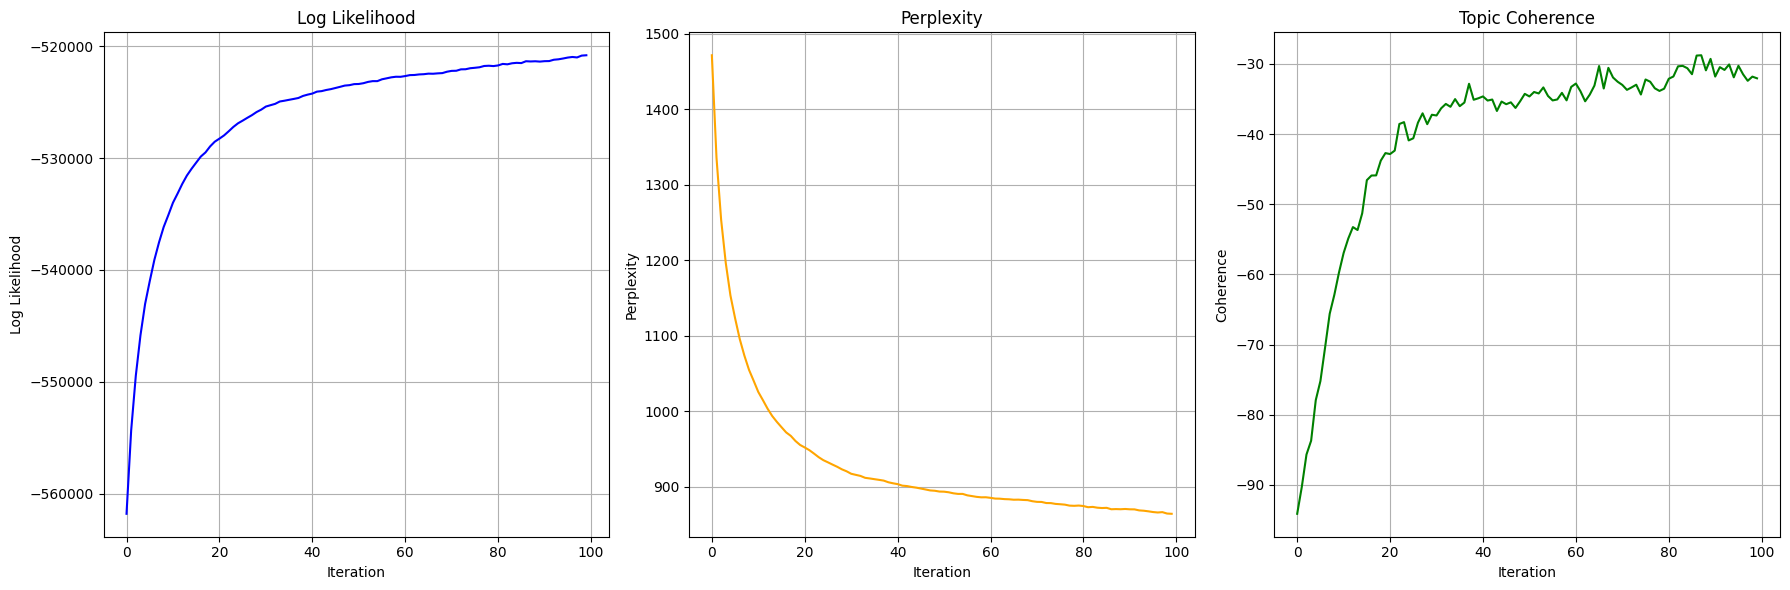

In [ ]:
# 결과 시각화
lda_cgs.plot_result()

## **4-1. topic별 상위 단어 시각화**

In [ ]:
def plot_top_words(lda_model, index_to_vocab, top_n=10):
  fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True)
  axes = axes.flatten()
  sns.set_palette("Set2", top_n)  # 색상 팔레트 설정 (Hue-Saturation-Lightness)

  for topic_idx, topic in enumerate(lda_model.topic_word_counts):
    top_word_indices = topic.argsort()[-top_n:][::-1]
    top_words = [index_to_vocab[i] for i in top_word_indices]
    weights = topic[top_word_indices]

    ax = axes[topic_idx]
    ax.barh(top_words, weights, color=sns.color_palette("husl", top_n))
    ax.set_title(f'Topic {topic_idx + 1}')
    ax.invert_yaxis()

  plt.tight_layout()
  plt.show()

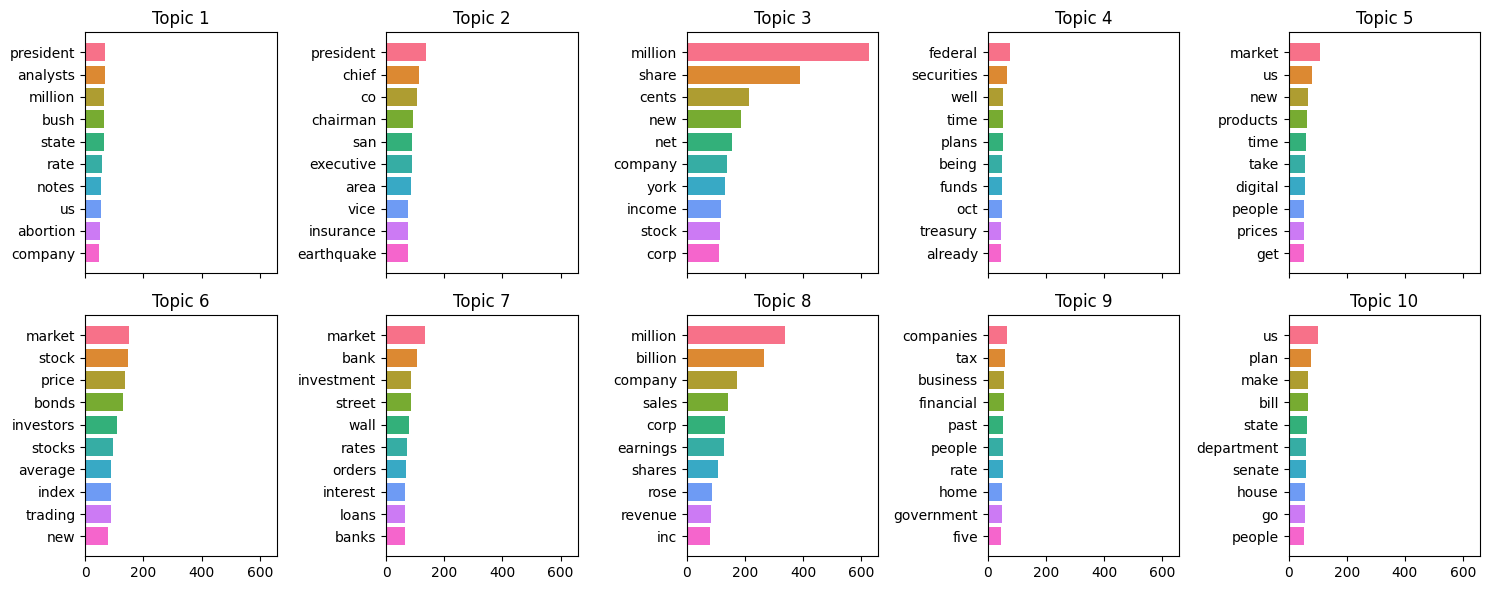

In [ ]:
plot_top_words(lda_cgs, i_t_v, top_n=10)

## **4-2. Topic 분포 시각화**

In [ ]:
def plot_doc_topics(lda_model, num_docs=15, top_n=10):
  num_docs = min(num_docs, lda_model.num_docs)  # 지정된 문서 개수가 전체 문서 수를 넘지 않도록 설정
  num_rows = (num_docs + 4) // 5  # 문서 개수에 따라 필요한 행 수 계산
  num_topics = lda_model.num_topics

  fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows), sharey=True)
  sns.set_palette("Set2", num_topics)

  # axes가 2D 배열이 아니라면, 단일 subplot인 경우를 처리
  if num_rows == 1:
    axes = np.expand_dims(axes, axis=0)

  # 주제 번호를 1부터 num_topics까지 순서대로 설정
  topic_labels = [f'{i + 1}' for i in range(num_topics)]

  for idx in range(num_docs):
    doc_topic_probs = lda_model.doc_topic_counts[idx, :]
    top_topic_indices = doc_topic_probs.argsort()[-top_n:][::-1]
    weights = doc_topic_probs[top_topic_indices]

    row_idx = idx // 5
    col_idx = idx % 5
    ax = axes[row_idx, col_idx]

    ax.bar(topic_labels, weights, color=sns.color_palette("Set2", num_topics))
    ax.set_title(f'Doc {idx + 1}', fontsize=10)
    ax.set_xlabel('Topics', fontsize=8)
    ax.set_ylabel('Proportion', fontsize=8)
    ax.set_xticks(range(num_topics))
    ax.set_xticklabels(topic_labels, fontsize=8)

  plt.tight_layout()
  plt.show()

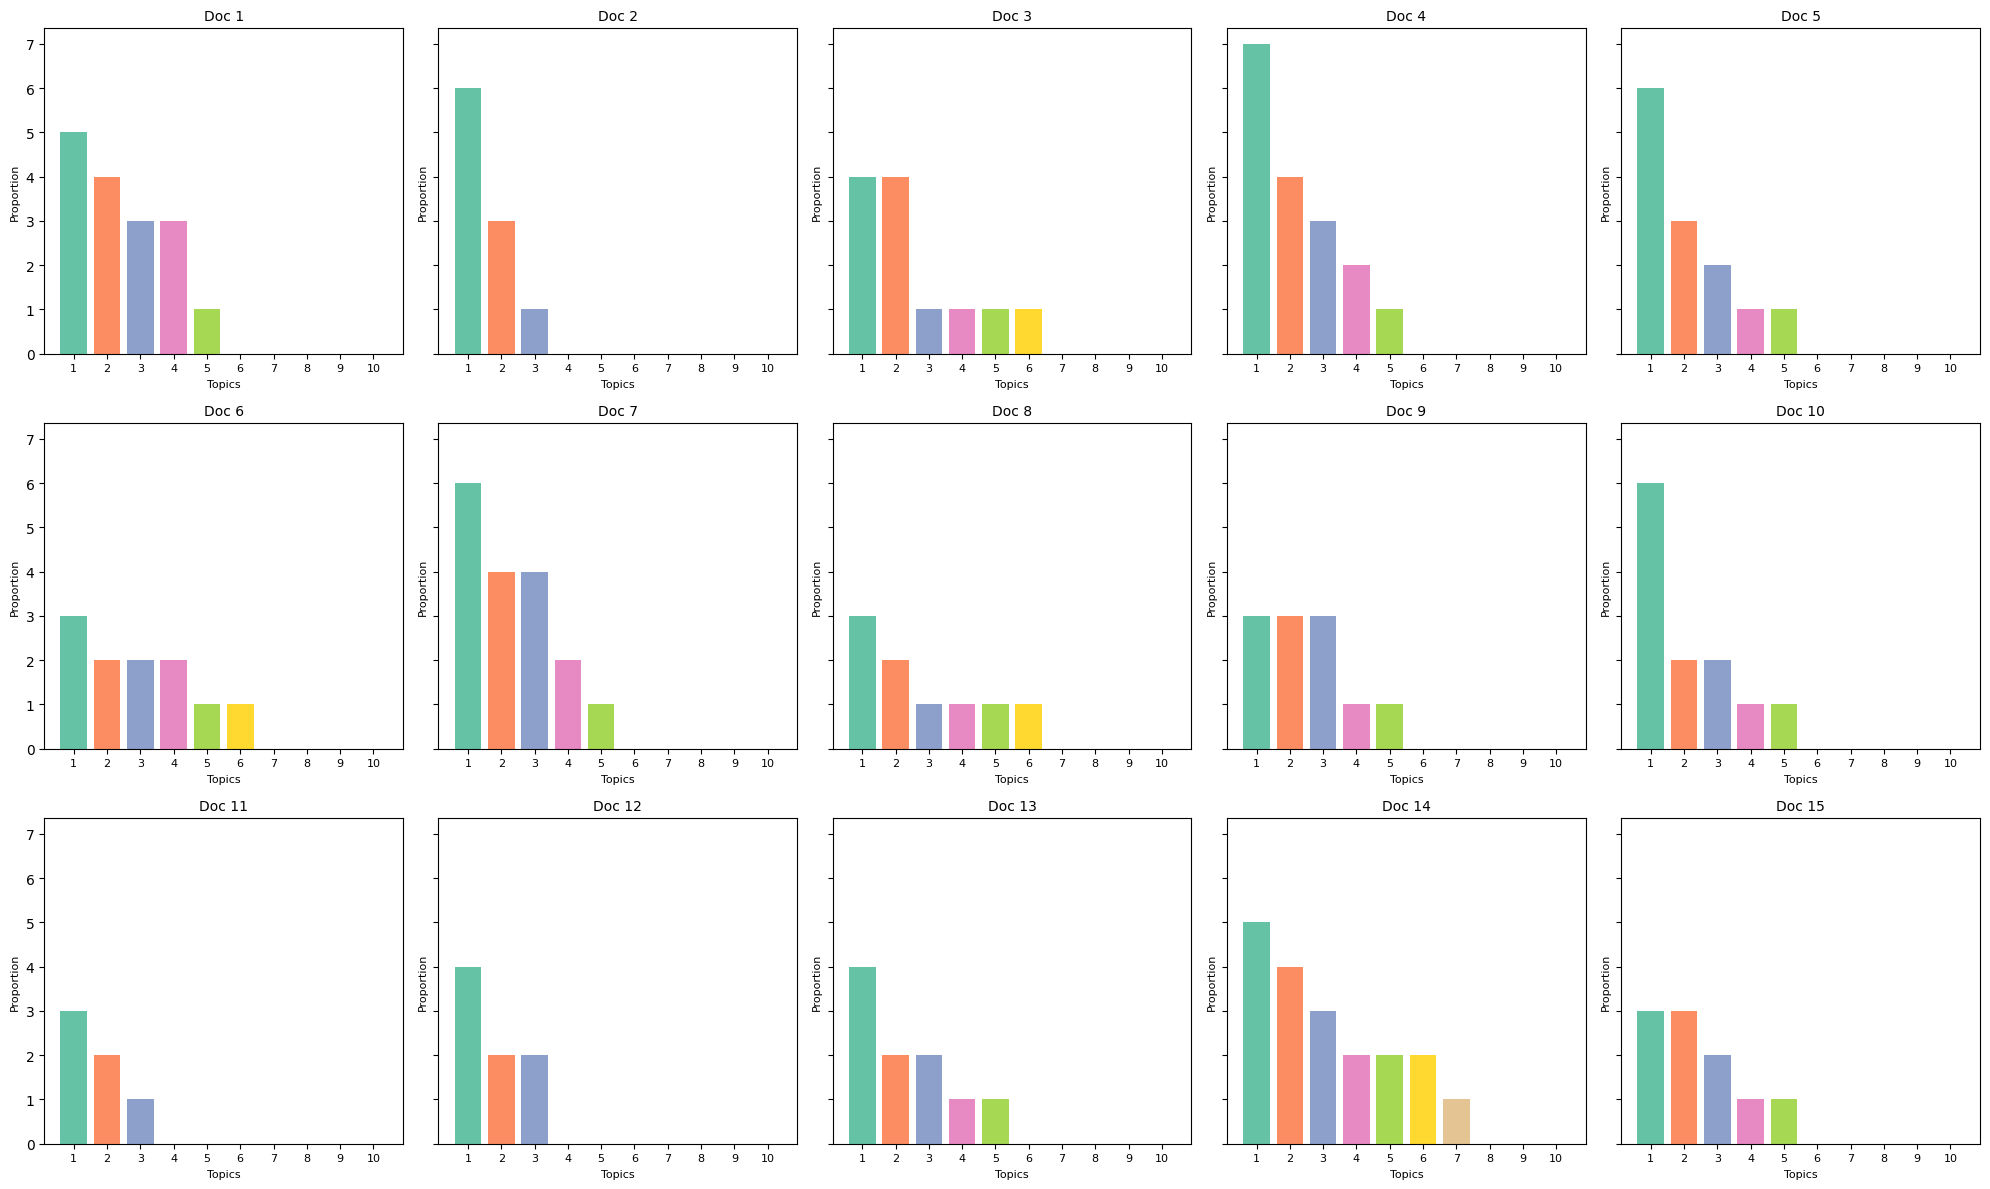

In [ ]:
plot_doc_topics(lda_cgs, num_docs=15, top_n = 10)

## **4-3. Topic 할당 시각화**

In [ ]:
from matplotlib.colors import to_hex
from IPython.core.display import HTML, display

In [ ]:
## Topic 별 색상 지정

def generate_topic_colors(num_topics):
  # Generate a color for each topic
  cmap = plt.get_cmap("Set2", num_topics)
  return [to_hex(cmap(i)) for i in range(num_topics)]

In [ ]:
## 단어의 topic 할당 확인

def get_topic_for_word(word, lda_model, vocab_to_index):
  word_id = vocab_to_index.get(word)
  if word_id is not None:
    # Find the topic with the highest probability for the word
    topic_probs = lda_model.topic_word_counts[:, word_id]
    return np.argmax(topic_probs)
  return None

In [ ]:
def visualize_document(document, lda_model, vocab_to_index, topic_colors):
  html_content = '<html><head><style>'
  html_content += 'body {font-family: Arial, sans-serif;} '
  html_content += '.word {padding: 2px; margin: 2px; display: inline-block;} '
  html_content += '</style></head><body>'

  # Get the topic for each word in the document
  for word in document:
    word_id = vocab_to_index.get(word)
    if word_id is not None:
      topic = get_topic_for_word(word, lda_model, vocab_to_index)
      if topic is not None:
        color = topic_colors[topic]
        html_content += f'<span class="word" style="color: {color};">{word}</span>'
      else:
        html_content += f'<span class="word">{word}</span>'
    else:
        html_content += f'<span class="word">{word}</span>'

  html_content += '</body></html>'

  # Display the HTML content inline
  display(HTML(html_content))

In [ ]:
topic_colors = generate_topic_colors(num_topics = 10)

selected_docs = org_train_data[:15]
for i, doc in enumerate(selected_docs):
  print(f"Document {i + 1}")
  visualize_document(doc, lda_cgs, v_t_i, topic_colors)

Document 1


Document 2


Document 3


Document 4


Document 5


Document 6


Document 7


Document 8


Document 9


Document 10


Document 11


Document 12


Document 13


Document 14


Document 15
